# Road Accident Risk

## Initialisation

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
#from lightgbm import LGBMRegressor
#from catboost import CatBoostRegressor
#from xgboost import XGBRegressor

### Code parameters

In [2]:
# Compute RMSE of the model (take few min)
CheckRMSE = False
# Save Submition in the output file
save = True

### Path

In [3]:
data_folder = 'resources/'
output_folder = 'output/'
plots_folder = 'output/plots/'

## Train Data loading

In [ ]:
train = pd.read_csv(data_folder + "train.csv")
X_train = pd.DataFrame(train.drop(["accident_risk", "id"], axis=1))
train.head(5)

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [5]:
y_train = pd.DataFrame(train["accident_risk"].copy())

y_train.head(5)

,accident_risk
0,0.13
1,0.35
2,0.30
3,0.21
4,0.56


In [6]:
X_train.dtypes

road_type                  object
num_lanes                   int64
curvature                 float64
speed_limit                 int64
lighting                   object
weather                    object
road_signs_present           bool
public_road                  bool
time_of_day                object
holiday                      bool
school_season                bool
num_reported_accidents      int64
dtype: object

## Data analysis

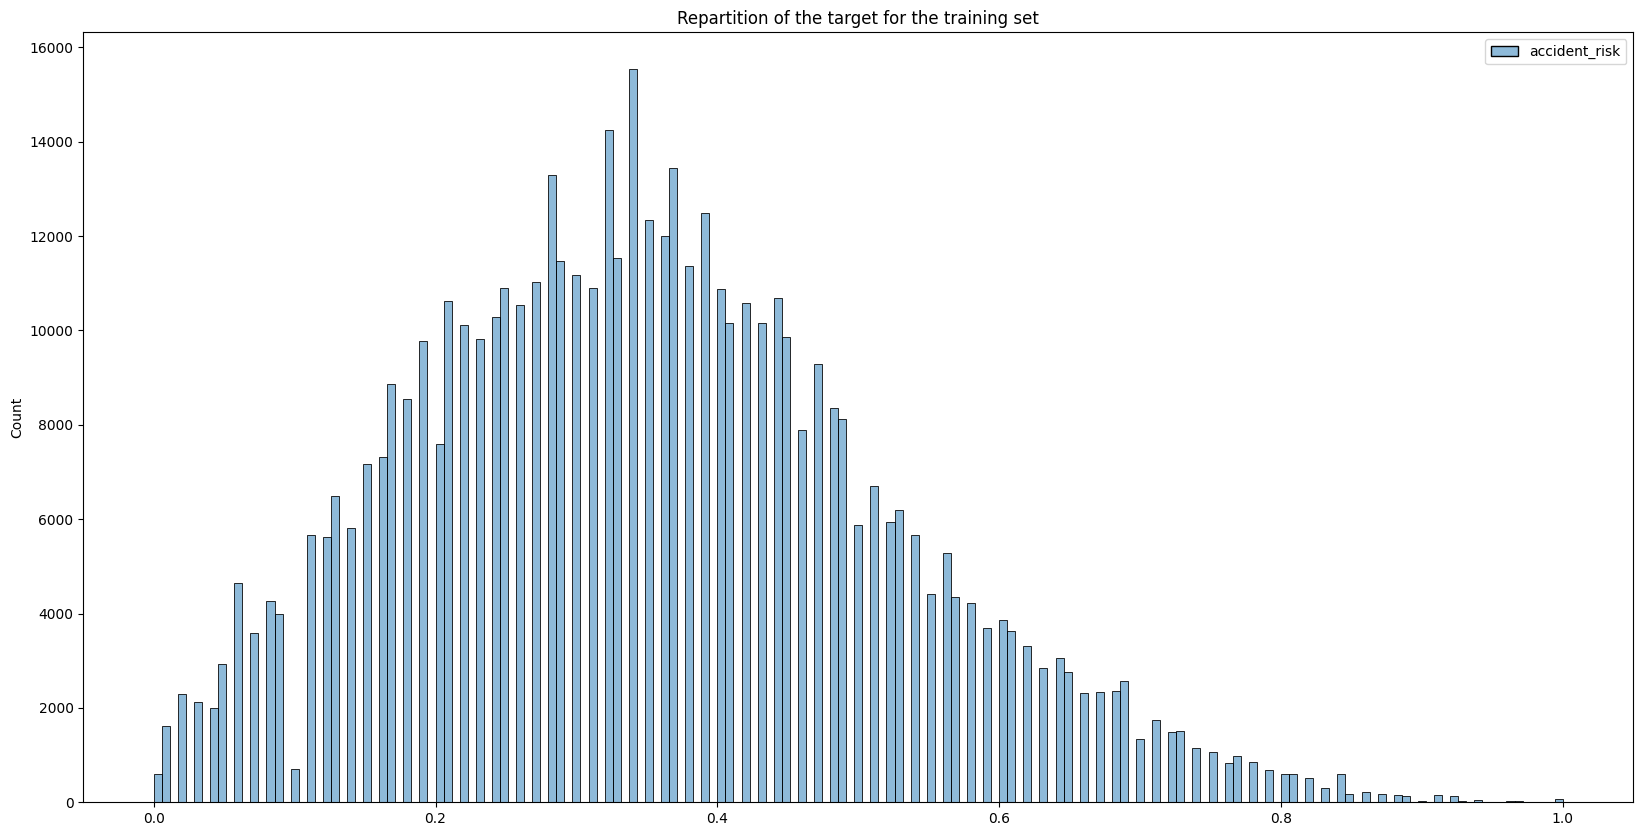

In [7]:
plt.figure(figsize=(20, 10))
sns.histplot(y_train)
plt.title('Repartition of the target for the training set')
plt.savefig(f"{plots_folder}Histplot_Ytrain.png")

## Train Preprocessing

### Missing values

In [8]:
X_train.isna().sum()

road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
dtype: int64

### Bool type processing

Bool data can be easily interpreted by integer (0 = False and 1 = True)

In [9]:
SRP = X_train["road_signs_present"].astype(int)
PR = X_train["public_road"].astype(int)
H = X_train["holiday"].astype(int)
SS = X_train["school_season"].astype(int)

X_train.dtypes

road_type                  object
num_lanes                   int64
curvature                 float64
speed_limit                 int64
lighting                   object
weather                    object
road_signs_present           bool
public_road                  bool
time_of_day                object
holiday                      bool
school_season                bool
num_reported_accidents      int64
dtype: object

### Object type processing

In [10]:
objType = X_train.select_dtypes(include="object").columns

objType

Index(['road_type', 'lighting', 'weather', 'time_of_day'], dtype='object')

#### road_type

In [11]:
X_train['road_type'].unique()

array(['urban', 'rural', 'highway'], dtype=object)

Only 3 value, we can encode them with Dummies variable without adding to much colunms.

In [12]:
RTdummies = pd.get_dummies(X_train['road_type']).astype(int)

print(RTdummies.shape[0] == X_train.shape[0])

RTdummies.head(5)

True


,highway,rural,urban
0,0,0,1
1,0,0,1
2,0,1,0
3,1,0,0
4,0,1,0


#### lighting

In [13]:
X_train['lighting'].unique()

array(['daylight', 'dim', 'night'], dtype=object)

Same processing as 'road_type'

In [14]:
Ldummies = pd.get_dummies(X_train['lighting']).astype(int)

print(Ldummies.shape[0] == X_train.shape[0])

Ldummies.head(5)

True


,daylight,dim,night
0,1,0,0
1,1,0,0
2,0,1,0
3,0,1,0
4,1,0,0


#### weather

In [15]:
X_train['weather'].unique()

array(['rainy', 'clear', 'foggy'], dtype=object)

Same processing as 'road_type'

In [16]:
Wdummies = pd.get_dummies(X_train['weather']).astype(int)

print(Wdummies.shape[0] == X_train.shape[0])

Wdummies.head(5)

True


,clear,foggy,rainy
0,0,0,1
1,1,0,0
2,1,0,0
3,0,0,1
4,0,1,0


#### time_of_day

In [17]:
X_train['time_of_day'].unique()

array(['afternoon', 'evening', 'morning'], dtype=object)

Same processing as 'road_type'

In [18]:
TODdummies = pd.get_dummies(X_train['time_of_day']).astype(int)

print(TODdummies.shape[0] == X_train.shape[0])

TODdummies.head(5)

True


,afternoon,evening,morning
0,1,0,0
1,0,1,0
2,0,0,1
3,0,0,1
4,0,1,0


### Concat

In [19]:
XTotal = pd.concat([TODdummies, Wdummies, Ldummies, RTdummies, 
                    SRP, PR, H, SS, 
                    X_train['num_lanes'], X_train['curvature'], X_train['speed_limit'], X_train['num_reported_accidents']]
                    , axis=1)

XTotal.head(5)

,afternoon,evening,morning,clear,foggy,rainy,daylight,dim,night,highway,rural,urban,road_signs_present,public_road,holiday,school_season,num_lanes,curvature,speed_limit,num_reported_accidents
0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,1,2,0.06,35,1
1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,1,1,4,0.99,35,0
2,0,0,1,1,0,0,0,1,0,0,1,0,0,1,1,0,4,0.63,70,2
3,0,0,1,0,0,1,0,1,0,1,0,0,1,1,0,0,4,0.07,35,1
4,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0.58,60,1


In [20]:
print(X_train.shape[0] == XTotal.shape[0])

True


### Scaler

In [21]:
#"""
scaler = StandardScaler()
#scaler.fit(XTotal)
#XTotal = pd.DataFrame(scaler.transform(XTotal))

for i in XTotal.select_dtypes(include=np.number).columns.tolist():
    XTotal[i]=scaler.fit_transform(XTotal[[i]])

XTotal.head(5)
#"""

,afternoon,evening,morning,clear,foggy,rainy,daylight,dim,night,highway,rural,urban,road_signs_present,public_road,holiday,school_season,num_lanes,curvature,speed_limit,num_reported_accidents
0,1.420863,-0.707882,-0.709644,-0.727866,-0.734575,1.515952,1.381479,-0.741954,-0.656421,-0.710451,-0.707520,1.421755,-0.998410,0.995498,-1.007020,1.004984,-0.438680,-1.572918,-0.703840,-0.209797
1,-0.703798,1.412664,-0.709644,1.373879,-0.734575,-0.659651,1.381479,-0.741954,-0.656421,-0.710451,-0.707520,1.421755,1.001593,-1.004522,0.993029,1.004984,1.346344,1.839137,-0.703840,-1.325918
2,-0.703798,-0.707882,1.409156,1.373879,-0.734575,-0.659651,-0.723862,1.347792,-0.656421,-0.710451,1.413388,-0.703356,-0.998410,0.995498,0.993029,-0.995041,1.346344,0.518342,1.512963,0.906324
3,-0.703798,-0.707882,1.409156,-0.727866,-0.734575,1.515952,-0.723862,1.347792,-0.656421,1.407557,-0.707520,-0.703356,1.001593,0.995498,-1.007020,-0.995041,1.346344,-1.536229,-0.703840,-0.209797
4,-0.703798,1.412664,-0.709644,-0.727866,1.361331,-0.659651,1.381479,-0.741954,-0.656421,-0.710451,1.413388,-0.703356,-0.998410,-1.004522,0.993029,-0.995041,-1.331192,0.334898,0.879591,-0.209797


## Model testing

### param testing

In [22]:
knn_grid_params = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 20],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50],
    'p': [1, 2]
}

lasso_grid_params = {
    'eps': [0.0001, 0.0005, 0.001, 0.005, 0.01],
    'n_alphas': [10, 100, 200, 300, 400, 500],
    'cv': [3, 4, 5, 6, 7, 8, 9, 10],
}

gb_grid_params =  {
    'n_estimators': [150, 200, 250, 300, 350, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.02, 0.03, 0.4, 0.06, 0.07],
    'max_depth': [6, 7, 8,  9, 10, 11, 12, 13, None],
    'max_features': ['sqrt'],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17,29],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 18, 20],
    'subsample': [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1],
    'random_state': [1, 2, 3, 4, 5, 42]
}

In [23]:
def get_params(X_train, y_train, model, grid_params):
    estimator = RandomizedSearchCV(model, grid_params, cv=5, n_iter=1, verbose=1, scoring='neg_mean_squared_error')
    estimator.fit(X_train, y_train)
    print(estimator.best_params_)
    return estimator.best_params_

In [24]:
#knn_params = get_params(XTotal, y_train, KNeighborsRegressor(), knn_grid_params)
#lasso_params = get_params(XTotal, y_train, LassoCV(), lasso_grid_params)
#gb_params = get_params(XTotal, y_train, GradientBoostingRegressor(), gb_grid_params)

Result for KNN : {'weights': 'uniform', 'p': 1, 'n_neighbors': 3, 'leaf_size': 10, 'algorithm': 'brute'}

Result for GB : {'subsample': 0.7, 'random_state': 42, 'n_estimators': 500, 'min_samples_split': 29, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 6, 'learning_rate': 0.07}

### Model generation

In [25]:
knn_params = {'weights': 'uniform', 'p': 1, 'n_neighbors': 3, 'leaf_size': 10, 'algorithm': 'brute'}
gb_params = {'subsample': 0.7, 'random_state': 42, 'n_estimators': 500, 'min_samples_split': 29, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 6, 'learning_rate': 0.07}

estimators = [
    ('gr', GradientBoostingRegressor(**gb_params)),
    ('knn', KNeighborsRegressor(**knn_params)),
]
model = StackingRegressor(estimators=estimators, final_estimator=RidgeCV(cv=5))
model.fit(XTotal, y_train)

C:\Users\xavie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_stacking.py:1041: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,estimators,"[('gr', ...), ('knn', ...)]"
,final_estimator,RidgeCV(cv=5)
,cv,None
,n_jobs,None
,passthrough,False
,verbose,0
,loss,'squared_error'
,learning_rate,0.07
,n_estimators,500
,subsample,0.7
,criterion,'friedman_mse'


## Fold + MRSE

In [ ]:
fold_number = 3 # 10min * fold

data = pd.concat([XTotal, y_train], axis=1)

kf = KFold(n_splits=fold_number, shuffle=True, random_state=42)

### Root mean square error

In [44]:
if(CheckRMSE):
    predTrain = model.predict(XTotal)
    RMSE = np.sqrt(mean_squared_error(predTrain, y_train))
    RMSE

## Test Preprocessing

In [45]:
test = pd.read_csv(data_folder + "test.csv")
id = test["id"]
test = test.drop("id", axis=1)
test.head(5)

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1
1,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0
2,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1
3,rural,4,0.95,35,daylight,rainy,False,False,afternoon,False,False,2
4,highway,2,0.86,35,daylight,clear,True,False,evening,False,True,3


### Missing value

In [46]:
test.isna().sum()

road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
dtype: int64

### Bool type processing

In [47]:
SRP = test["road_signs_present"].astype(int)
PR = test["public_road"].astype(int)
H = test["holiday"].astype(int)
SS = test["school_season"].astype(int)

### Object type processing

In [48]:
RTdummies = pd.get_dummies(test['road_type']).astype(int)
Ldummies = pd.get_dummies(test['lighting']).astype(int)
Wdummies = pd.get_dummies(test['weather']).astype(int)
TODdummies = pd.get_dummies(test['time_of_day']).astype(int)

### Concat

In [49]:
test = pd.concat([TODdummies, Wdummies, Ldummies, RTdummies, 
                    SRP, PR, H, SS, 
                    test['num_lanes'], test['curvature'], test['speed_limit'], test['num_reported_accidents']]
                    , axis=1)

test.isna().sum()

afternoon                 0
evening                   0
morning                   0
clear                     0
foggy                     0
rainy                     0
daylight                  0
dim                       0
night                     0
highway                   0
rural                     0
urban                     0
road_signs_present        0
public_road               0
holiday                   0
school_season             0
num_lanes                 0
curvature                 0
speed_limit               0
num_reported_accidents    0
dtype: int64

### Scaler

In [50]:
#"""
for i in X_train.select_dtypes(include=np.number).columns.tolist():
    X_train[i]=scaler.fit_transform(X_train[[i]])
    test[i]=scaler.transform(test[[i]])

test.head(5)
#"""

,afternoon,evening,morning,clear,foggy,rainy,daylight,dim,night,highway,rural,urban,road_signs_present,public_road,holiday,school_season,num_lanes,curvature,speed_limit,num_reported_accidents
0,1,0,0,1,0,0,0,0,1,1,0,0,1,1,1,1,2.0,0.34,45.0,1.000000e+00
1,1,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,3.0,0.04,45.0,1.766222e-17
2,1,0,0,1,0,0,0,1,0,0,0,1,1,0,1,1,2.0,0.59,35.0,1.000000e+00
3,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,4.0,0.95,35.0,2.000000e+00
4,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,2.0,0.86,35.0,3.000000e+00


## Model fitting + prediction

In [51]:
predictions = []

for fold, (train_idx, test_idx) in enumerate(kf.split(XTotal), 1):

    X_tr, X_te = XTotal.iloc[train_idx], XTotal.iloc[test_idx]
    y_tr, y_te = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # Fit + evaluation
    model.fit(X_tr, y_tr)
    print("end of model : " + str(fold))

    predictions.append(model.predict(test))
    print("end of prediction : " + str(fold))

C:\Users\xavie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_stacking.py:1041: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


end of model : 1
end of prediction : 1


C:\Users\xavie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_stacking.py:1041: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


end of model : 2
end of prediction : 2


C:\Users\xavie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_stacking.py:1041: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


end of model : 3
end of prediction : 3


C:\Users\xavie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_stacking.py:1041: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


end of model : 4
end of prediction : 4


C:\Users\xavie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_stacking.py:1041: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


end of model : 5
end of prediction : 5


## Prediction

In [52]:
#prediction = model.predict(test)

In [ ]:
prediction = [sum(values) / len(values) for values in zip(*predictions)]


0.6740115866669625

### ConcatFile

In [ ]:
conc = False
if(conc):
    files = []
    files.append(pd.read_csv(output_folder + 'submission_boostrap3.csv', usecols=[1]))
    files.append(pd.read_csv(output_folder + 'submission_GB_KNN_R.csv', usecols=[1]))
    files.append(pd.read_csv(output_folder + 'submission_boostrap1.csv', usecols=[1]))

    # Fusionne les 3 DataFrames colonne par colonne
    combined = pd.concat(files, axis=1)

    # Conversion automatique en float (au cas où certaines sont encore des str)
    combined = combined.apply(pd.to_numeric, errors='coerce')

    # Moyenne ligne par ligne
    prediction = combined.mean(axis=1)

    #prediction = [sum(values) / len(values) for values in zip(*files)]


0         0.288667
1         0.121333
2         0.189667
3         0.358000
4         0.393667
            ...   
172580    0.113000
172581    0.520333
172582    0.247333
172583    0.136667
172584    0.498000
Length: 172585, dtype: float64

### Saving data

In [122]:
filename = output_folder + 'submission_combined3.csv'

pred = []
for i in prediction:
    pred.append(round(i, 3))

submission = pd.DataFrame({
    'id': id,
    'accident_risk': pred
})

submission.to_csv(filename, index=False)
print(f"Saved: {filename}")

Saved: output/submission_combined3.csv
